# Modules

In [1]:
from datetime import timedelta
from IPython.display import clear_output
import nolds

import numpy as np
from scipy.signal import argrelextrema, find_peaks
from scipy.optimize import curve_fit
import nolds

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, rgb2hex

from mesa import Agent, Model
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.time import SimultaneousActivation
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter

# Helper functions

Obtain the sum of the fractions across all FSM's in the CA.

In [2]:
def get_sus(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[0]
    return state

def get_exp(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[1]
    return state

def get_inf(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[2]
    return state

def get_rec(model):
    state = 0
    for (contents, i, j) in model.grid.coord_iter():
        state += contents.state[3]
    return state

# CA class
* Set all parameters as "global" parameters, i.e., all FSMs have the same params.
* Set a global time t (days)
* Random give some FSMs a state $(0.8, 0, 0.2, 0)$ instead of $(1, 0, 0, 0)$

In [31]:
class CellularAutomaton(Model):
    
    def __init__(
        self,
        height = 30,
        width = 30,
        mu = 0.0005, # Birth rate
        sig = 1/7,   # Rate of delay
        gam = 1/14,  # Rate of recovery
        c = 1/2,     # Connection factor between FSM
        b0 = 0.25,   # Rate of infection
        b1 = 0.2,    # Amplitude of seasonality of infection
        dt = 0.001,
        manual_init = False,    # Boolean, use if you want to specify initial conditions
        init_coords = None, # array of 2-tuples (sort by first value of tuple) representing coordinates for which to specify conditions
        init_states = None, # array of same lentgh as coords with 4-tuples specifying SEIR proportions
        n = 0 
    ):
        self.height = height
        self.width = width
        
        self.mu = mu
        self.b0 = b0
        self.b1 = b1
        self.sig = sig
        self.gam = gam
        self.c = c
        self.n = n
        
        self.t = 0
        self.dt = dt
        self.manual_init = manual_init
        self.init_coords = init_coords
        self.init_states = init_states
        
        self.schedule = SimultaneousActivation(self)
        self.grid = Grid(self.width, self.height, torus=True)

        self.datacollector = DataCollector(
            model_reporters =  {
                "sus": get_sus,
                "exp": get_exp,
                "inf": get_inf,
                "rec": get_rec
                }
            )
        
        count = 0
        
        # sets initial states if defined
        count = 0 # how many specified initial coordinates have been set
        if self.manual_init:
            for (contents, i, j) in self.grid.coord_iter():
                FSM = FSM_SEIR((i, j), self)
                if (i, j) in self.init_coords:
                    FSM.state = self.init_states[count]
                    count += 1
                else:
                    FSM.state = [0.0423, 0.003, 0.0021, 0.9704]
                self.grid.place_agent(FSM, (i,j))
                self.schedule.add(FSM)

                
        else:
            for (contents, i, j) in self.grid.coord_iter():
                FSM = FSM_SEIR((i,j), self)

                if np.random.random() < 0.1:
                    FSM.state = [0]*4
                    FSM.state[0] = 0.8
                    FSM.state[2] = 0.2

                    count += 1
                else:
                    FSM.state = [0.0423, 0.003, 0.0021, 0.9704]
                self.grid.place_agent(FSM, (i,j))
                self.schedule.add(FSM)
        
        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.t += 1
        self.schedule.step()
        self.datacollector.collect(self)

    def run(self, n):
        for _ in range(n):
            self.step()

# FSM class

* States: $(S, I, E, R)$, where each of the attributes is a fraction of the form $\frac{n}{10^n}, \quad n \in \mathbb{N}$. It follows that each FSM has $(10^n +1)^4$ different states it can attain.
* Transition function:
$$ S_{i,j}^{t+1} = S_{i,j}^t - \beta(t) S_{i,j}^tI_{i,j}^t - c\beta(t)\sum_{k,l} I_{k,l}^t S_{i,j}^t + \mu (1 - S_{i,j}^t), $$
$$ E_{i,j}^{t+1} = E_{i,j}^t + \beta(t) S_{i,j}^tI_{i,j}^t + c\beta(t)\sum_{k,l} I_{k,l}^t S_{i,j}^t - \sigma E_{i,j}^t - \mu E_{i,j}^t,$$
$$ I_{i,j}^{t+1} = I_{i,j}^t + \sigma E_{i,j}^t - \gamma  I_{i,j}^t - \mu * I_{i,j}^t, $$
$$ R_{i,j}^{t+1} = R_{i,j}^t + \gamma I_{i,j}^t - \mu R_{i,j}^t, $$
where $\beta(t) = \beta_0 (1 + \beta_1\cos(\omega t))$.

In [34]:
class FSM_SEIR(Agent):
    def __init__(self, pos, model):
        super().__init__(pos, model)
        self.x, self.y = pos

        self.state = None
        self._nextState = None
        self.counter = 0

    def step(self):
        neighbors = self.model.grid.get_neighbors((self.x,self.y), True)
        
        S,E,I,R = self.state
        
        F = 2*np.pi/100 # Period of temporal forcing
        omega = F
        
        beta = self.model.b0 * (1 + self.model.b1 * np.cos( omega * self.model.t))
        
        Snew = S + (- beta * S * I - sum([self.model.c * beta * x.state[2] * S for x in neighbors]) + self.model.mu * (1 - S)) * self.model.dt
        Enew = E + (beta * S * I + sum([self.model.c * beta * x.state[2] * S for x in neighbors]) - E * self.model.sig - self.model.mu * E) * self.model.dt
        Inew = I + (E * self.model.sig - I * self.model.gam - self.model.mu * I) * self.model.dt
        Rnew = R + (I * self.model.gam - self.model.mu*R) * self.model.dt
        
        # Map to state space
        n = self.model.n
        if n == 0:
            S = Snew
            E = Enew
            I = Inew
            R = Rnew
        else:
            S = round(Snew, n)
            E = round(Enew, n)
            I = round(Inew, n)
            R = round(Rnew, n)
        
        self._nextState = [S, E, I, R]
        
    def advance(self):
        self.state = self._nextState

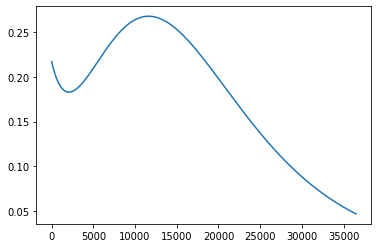

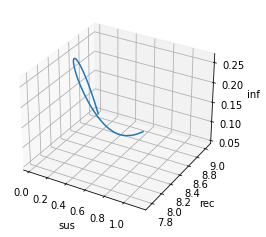

In [35]:
model = CellularAutomaton( 
        height = 3,
        width = 3,
        mu = 0.02/365, # Birth rate
        sig = 1/8,     # Rate of delay
        gam = 1/5,     # Rate of recovery
        c = 1/2,       # Connection factor between FSM
        b0 = 1,        # Rate of infection
        b1 = 0.2       # Amplitude of seasonality of infection
 # FSN states parameter, n=0 equals machine precision states        
        )

model.run(100*365)

df = model.datacollector.get_model_vars_dataframe()
df['inf'].plot()
plt.show()

ax = plt.axes(projection='3d')
ax.plot3D(df['sus'], df['rec'], df['inf'])
ax.set_xlabel('sus')
ax.set_ylabel('rec')
ax.set_zlabel('inf')
plt.show()

In [ ]:
# Lyapunov exponent

In [36]:
ϵ = 0.001 # amount of peturbation
height = 3
width = 3
mu = 0.02/365  # Birth rate
sig = 1/8  # Rate of delay
gam = 1/5 # Rate of recovery
c = 1/2     # Connection factor between FSM
b0 = 1   # Rate of infection
b1 = 0.25  # Amplitude of seasonality of infection
dt = 0.001
m = 100  # number of times model is run with different initializations
n = 50000   # number of timesteps for each model

# store trajectories of two close initial conditions
infected = np.zeros((m, n+1))
infected_eps = np.zeros((m, n+1))

for i in range(m):
    print(i)
    [S, E, I, R] = np.random.random(size=4)
    
    # make sure the sum equals 1 
    [S, E, I, R] = [S, E, I, R] / np.sum([S, E, I, R])
    
    # model with random initial conditions
    model = CellularAutomaton( 
            height = height, width = width, mu = mu, sig = sig, gam = gam, c= c, b0 = b0, b1 = b1,  
            dt=dt, manual_init = True, init_coords = [(0,0)], init_states = [tuple([S, E, I, R])])
    
    # model with initial conditions + peturbation
    model_eps = CellularAutomaton( 
            height = height, width = width, mu = mu, sig = sig, gam = gam, c= c, b0 = b0, b1 = b1,  
            dt=dt, manual_init = True, init_coords = [(0, 0)], init_states = [tuple([abs(S-ϵ), E, I+ϵ, R])])

    model.run(n)
    model_eps.run(n)

    df = model.datacollector.get_model_vars_dataframe()
    df_eps = model_eps.datacollector.get_model_vars_dataframe()
    
    infected[i] = df['inf']
    infected_eps[i] = df_eps['inf']

0
1


In [37]:
from scipy.stats import linregress

# start when the initial spread has faded
start = 20000
time = np.arange(start, n+1, 1)

# slopes, intercept, slope standard error
fits = np.zeros((m, 3))

# differences between f(x0) and f(x0 + eps)
diffs = np.zeros((m, n+1-start))

for i in range(m):

    diffs[i] = np.log(np.abs(infected[i, start:]-infected_eps[i, start:]))

    # linear regression
    lin_fit = linregress(time, diffs[i])
    fits[i] = [lin_fit.slope, lin_fit.intercept, lin_fit.stderr]

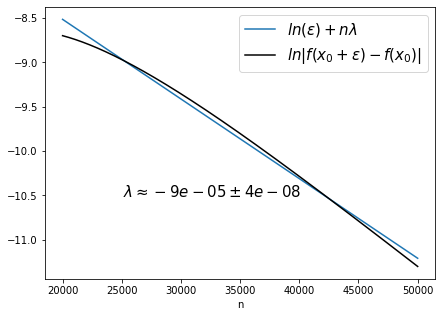

In [30]:
# find model index with highest lyapunov exponent
max_slope = 0 #np.where(max(fits[0, :]))[0][0]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(time, fits[max_slope, 0]*time + fits[max_slope, 1], label='$ln(\epsilon) + n \lambda$')
plt.plot(time, (diffs[max_slope]), 'k-', label=r'$ln|f(x_0+\epsilon) - f(x_0)|$')
plt.legend(fontsize=15)
plt.text(0.2, 0.3, rf'$\lambda \approx{round(fits[max_slope, 0], 5)} \pm {round(fits[max_slope, 2], 8)}$', transform=ax.transAxes, fontsize=15)
plt.xlabel('n')
plt.savefig('lyapunov_fit.png', dpi=300)
plt.show()

In [ ]:
# lyapunov exponents using nolds library
print(nolds.lyap_e(infected[max_slope, start:]), nolds.lyap_r(infected[max_slope, start:]))

# Lyapunov exponents based on amplitude $(\beta_1)$

In [ ]:
betas = np.linspace(0, 1, 10)

for i in range(len(betas)):
    print(i)
    [S, E, I, R] = np.random.random(size=4)
    
    # make sure the sum equals 1 
    [S, E, I, R] = [S, E, I, R] / np.sum([S, E, I, R])
    
    # model with random initial conditions
    model = CellularAutomaton( 
            height = height, width = width, mu = mu, sig = sig, gam = gam, c= c, b0 = b0, b1 = b1,  
            dt=dt, manual_init = True, init_coords = [(0,0)], init_states = [tuple([S, E, I, R])])
    
    # model with initial conditions + peturbation
    model_eps = CellularAutomaton( 
            height = height, width = width, mu = mu, sig = sig, gam = gam, c= c, b0 = b0, b1 = b1,  
            dt=dt, manual_init = True, init_coords = [(0, 0)], init_states = [tuple([abs(S-ϵ), E, I+ϵ, R])])

    model.run(n)
    model_eps.run(n)

    df = model.datacollector.get_model_vars_dataframe()
    df_eps = model_eps.datacollector.get_model_vars_dataframe()
    
    infected[i] = df['inf']
    infected_eps[i] = df_eps['inf']

In [ ]:
# slopes, intercept, slope standard error
fits = np.zeros((m, 3))

# differences between f(x0) and f(x0 + eps)
diffs = np.zeros((len(betas), n+1-start))

lyap_exps = np.zeros(len(betas))

for i in range(len(betas)):

    diffs[i] = np.log(np.abs(infected[i, start:]-infected_eps[i, start:]))

    # linear regression
    lin_fit = linregress(time, diffs[i])
    lyap_exps[i] = lin_fit.slope

In [ ]:
plt.plot(betas, lyap_exps)
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$\beta_1$')
plt.show()
print(lyap_exps)

# Bifurcation diagram

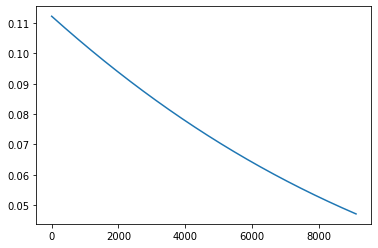

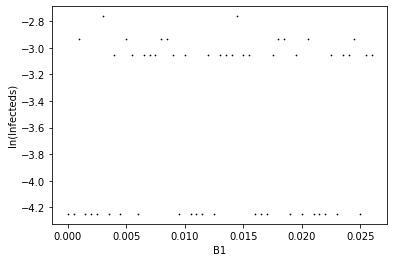

min remaining: 346.36
b1:  0.0265


In [ ]:
# iterate over b1 values and create plots per model run
import time

b1_vals = []
b1_infs = []

start_time = time.time()
b1_iter = np.arange(0, 0.3, 0.0005) # b1 values to create bifurcation diagram for
for i, b1 in enumerate(b1_iter):
    
    print("b1: ", b1)
    
    # set model params
    model = CellularAutomaton( 
            height = 3,
            width = 3,
            mu = 0.02/365, # Birth rate
            sig = 1/8,     # Rate of delay
            gam = 1/5,     # Rate of recovery
            c = 1/2,       # Connection factor between FSM
            b0 = 1,        # Rate of infection
            b1 = b1,       # Amplitude of seasonality of infection
            n = 0          # FSN states parameter, n=0 equals machine precision states
                             )

    model.run(100*365)

    # collect data
    df = model.datacollector.get_model_vars_dataframe()
    Infected = df['inf'].tolist()[75*365:] # collect infecteds data from 75-100 years
    
    # find peaks
    peaks, _ = find_peaks(Infected)
    infs = list(set([Infected[peak] for peak in peaks]))
    for inf in infs:
        b1_vals.append(b1)
        b1_infs.append(inf)

    # find troughs
    troughs, _ = find_peaks([-1*inf for inf in Infected])
    infs = list(set([Infected[trough] for trough in troughs]))
    for inf in infs:
        b1_vals.append(b1)
        b1_infs.append(inf)
    
    # if no peak or through then no oscillations in infecteds
    # thus add infecteds stable value
    if len(peaks) == 0 and len(troughs) ==0:
        b1_vals.append(b1)
        b1_infs.append(Infected[-1])
    
    # plot progress
    clear_output()

    for trough in set(troughs):
        plt.axvline(trough, c='g')
        plt.plot(trough, Infected[trough], 'o', c='g')
    for peak in set(peaks):
        plt.axvline(peak, c='r')
        plt.plot(peak, Infected[peak], 'o', c='r')
    plt.plot(Infected)
    plt.show()

    plt.scatter(b1_vals, [np.log(inf) for inf in b1_infs], marker='.', c='k', s=2)
    plt.xlabel("B1")
    plt.ylabel("ln(Infecteds)")
    plt.show()
    
    print("min remaining:", round((time.time() - start_time)/(i+1)*(len(b1_iter) - (i+1))/60, 2))

In [ ]:
# create final bifurcation diagram

# b1 values for oscillatory infected plots and corresponding 
# axvlines in bifurcation diagram
slices = [0.10, 0.205, 0.27] 

plt.figure(figsize=(12, 3), dpi=200)
plt.scatter(b1_vals, [np.log(inf) for inf in b1_infs], c='k', marker='.', s=1)
plt.xlabel("B1")
plt.ylabel("ln(Infecteds)")
for B1 in slices:
    plt.axvline(B1, c='k', ls='--')
plt.show()

In [ ]:
# create plots for the b1 slice values from the bifurcation diagram

for b1 in slices:
    
    # set model params
    model = CellularAutomaton( 
            height = 3,
            width = 3,
            mu = 0.02/365, # Birth rate
            sig = 1/8,     # Rate of delay
            gam = 1/5,     # Rate of recovery
            c = 1/2,       # Connection factor between FSM
            b0 = 1,        # Rate of infection
            b1 = b1,       # Amplitude of seasonality of infection
            n = 0          # FSN states parameter, n=0 equals machine precision states
                             )

    # run model for 100 years
    model.run(100*365)

    # collect data
    df = model.datacollector.get_model_vars_dataframe()
    Infected = df['inf'].tolist()[75*365:]
    
    # find peaks
    peaks, _ = find_peaks(Infected)

    # find troughs
    troughs, _ = find_peaks([-1*inf for inf in Infected])

    # create plots
    plt.figure(figsize=(4, 3), dpi=200)
    for trough in set(troughs):
        plt.plot(trough, np.log(Infected[trough]), 'o', c='k')
    for peak in set(peaks):
        plt.plot(peak, np.log(Infected[peak]), 'o', c='k')
    plt.plot([np.log(inf) for inf in Infected], label=f'{b1}', c='k')
    plt.ylabel("ln(Infecteds)")
    plt.xlabel("time in days, range(75-100 years)")
    plt.show()

In [ ]:
ϵ = 0.001 # amount of peturbation
height = 3
width = 3
mu = 0.02/365  # Birth rate
sig = 1/8  # Rate of delay
gam = 1/5 # Rate of recovery
c = 1/2     # Connection factor between FSM
b0 = 1   # Rate of infection
b1 = 0.25  # Amplitude of seasonality of infection
dt = 0.001 # timestep
m = 2 # number of times model is run with different initializations
n = 50000   # number of timesteps for each model

infected = np.zeros((m, n+1))
infected_eps = np.zeros((m, n+1))

for i in range(m):
    print(i)
    
    # initial conditions
    [S, E, I, R] = np.random.random(size=4)   
    # make sure the sum equals 1 
    [S, E, I, R] = [S, E, I, R] / np.sum([S, E, I, R])
    
    # model with random initial conditions
    model = CellularAutomaton( 
            height = height, width = width, mu = mu, sig = sig, gam = gam, c= c, b0 = b0, b1 = b1,  
            manual_init = False, init_coords = [(0,0)], init_states = [tuple([S, E, I, R])])
    
    # model with initial conditions + peturbation
    # In theory I can now be larger than 1 but it is not very likely
    model_eps = CellularAutomaton( 
            height = height, width = width, mu = mu, sig = sig, gam = gam, c= c, b0 = b0, b1 = b1,  
            manual_init = False, init_coords = [(0, 0)], init_states = [tuple([abs(S-ϵ), E, I+ϵ, R])])

    model.run(n)
    model_eps.run(n)

    df = model.datacollector.get_model_vars_dataframe()
    df_eps = model_eps.datacollector.get_model_vars_dataframe()
    
    infected[i] = df['inf']
    infected_eps[i] = df_eps['inf']

# CA infecteds over time: animated

In [ ]:
frameskip = 10 # how many frames/days to skip between frames

# init plot
fig = plt.figure(figsize = (15,15))
ax = plt.axes()

max_inf = np.max([df["CA_inf"][i].max() for i in range(len(df))]) # max infecteds to scale colors accordingly
a=np.zeros(df["CA_inf"][0].shape)
im=plt.imshow(a,interpolation='none', vmin=0, vmax=max_inf, cmap = 'hot')

def animate(i):
    im.set_array(df["CA_inf"][i*(frameskip + 1)])
    ax.set_title(f"t={i*(frameskip + 1)}", fontsize=50)
    return [im]

plt.axis('off')
for item in [fig, ax]:
    item.patch.set_visible(False)
plt.colorbar()

anim = FuncAnimation(fig, animate, frames=int(len(df)/(frameskip + 1)), interval=50*(frameskip + 1), blit=True) 
anim.save('CA_ani.gif')
plt.clf()

# show animated plot in notebook
# random argument to work around browser cache
rand = np.random.random()
HTML(f'<img src="CA_ani.gif?{rand}">')

# Convergence of infecteds cell state differences

In [ ]:
plt.plot([df["CA_inf"][i].std() for i in range(len(df))][:20000], c="k", linewidth=0.5)
plt.xlabel("time in days")
plt.ylabel("Infecteds standard deviation")
plt.yscale("log")
plt.show()

plt.plot(df["inf"][:20000], c="k", linewidth=0.5)
plt.xlabel("time in days")
plt.ylabel("Infecteds")
plt.show()

# MESA server

In [ ]:
norm = Normalize(vmin=0, vmax = 0.5)
cmap = cm.Greys
m = cm.ScalarMappable(norm = norm, cmap = cmap)

colordict = {}

for i in np.linspace(0,1,10001):
    k = round(10000*i)/10000
    colordict[k] = rgb2hex(m.to_rgba(k))

def portrayCell(fsm):
    assert fsm is not None
    
    portrayal = {
        "Shape": "rect",
        "w":1,
        "h":1,
        "Filled": "true",
        "Layer": 0,
        "x": fsm.x,
        "y": fsm.y
    }
    portrayal["Color"] = colordict[fsm.state[2]]
    
    return portrayal

chart = ChartModule(
    [{"Label": "sus", "Color": "#3776ab"},
     {"Label": "exp", "Color": '#ab3776'},
     {"Label": "inf", "Color": "#ab6b37"}, 
     {"Label": "rec", "Color": "#37ab6c"}],
     canvas_height=300, canvas_width=500
)

SIZE = 50

canvas_element = CanvasGrid(portrayCell, SIZE, SIZE, 500, 500 )
server = ModularServer(
    CellularAutomaton, [canvas_element,chart], "Epidemic", {"height": SIZE, 
                                                            "width":SIZE,
                                                            "mu": 0.0005, # Birth rate
                                                            "sig": 1/8,   # Rate of delay
                                                            "gam": 1/5,   # Rate of recovery
                                                            "c": 1/2,     # Connection factor between FSM
                                                            "b0": 1,      # Rate of infection
                                                            "b1": 0.2     # Amplitude of seasonality of infection
                                                           }
    )

server.launch()